## Figure for manuscript to represent HMF metrics
<ul>
1. Annual HMF - <br>
2. Event HMF - <br>
3. Annual Duration - <br>
4. Event Duration - <br>
5. Intra-Annual Frequnecy - <br>
6. Timing - <br>
7. Inter-Annual Frequency - <br>

In [2]:
# Imports
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

from matplotlib.dates import MonthLocator, DateFormatter # for plotting month on x-axis
import matplotlib.dates as mdates

# Custom libs
import Src.func_ko as fn
import Src.classes as cl
reload(fn)
reload(cl)

<module 'Src.classes' from 'C:\\Users\\kondr\\Documents\\GitHub\\DahlkeLab_LAWR\\Src\\classes.py'>

In [3]:
# Controls
# '11447650' -- SRB
# '11303500' -- SJB
# '03575830' -- testsite
site_no = '11447650'

K_DEFAULT_START = '1900-10-01'
K_DEFAULT_END = '2015-09-30' # end date for Kocis paper

DEFAULT_START = '1900-10-01'
DEFAULT_END = '2020-09-30' # end date for this study
df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=K_DEFAULT_START, end=K_DEFAULT_END)

if site_no == '11447650':
    df1 = nwis.get_record(sites=str(site_no), service=fn.SERVICE, start=K_DEFAULT_START, end =K_DEFAULT_END, parameterCd='00060')
    df2 = nwis.get_record(sites=str(site_no), service=fn.SERVICE, start='2015-09-01', end=DEFAULT_END, parameterCd='72137')
    df = pd.concat([df1, df2])
    df.loc[df['00060_Mean'].isna(), '00060_Mean'] = df.loc[df['00060_Mean'].isna(), '72137_Mean']

# Aquifer analysis is done on both 30 and 50-year periods with both 90 and 95% quantiles
data_range = 30 
quantile = 0.90
CFS_TO_CMS = 0.028316846592

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


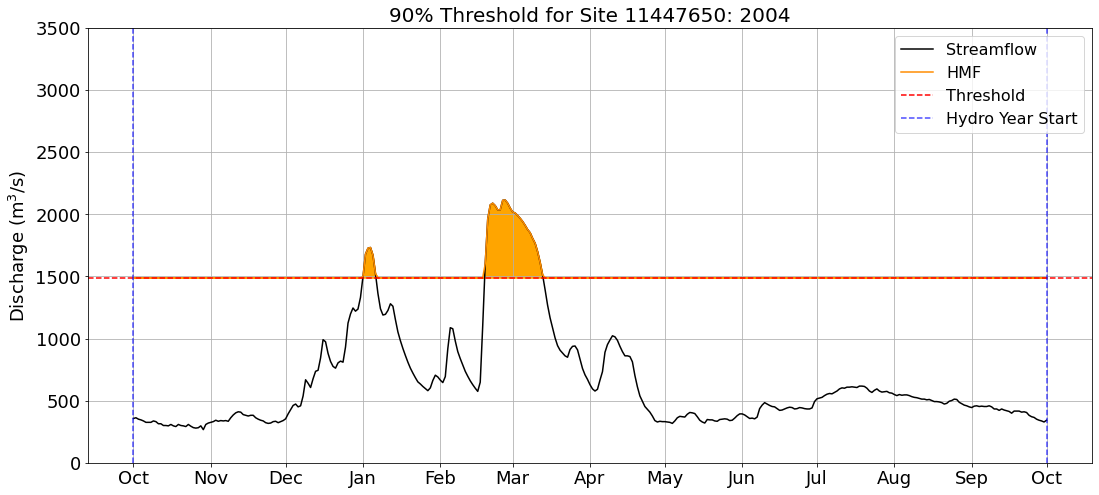

In [4]:
df_plot = df.reset_index()

threshold = fn.calc_threshold(df_plot, quantile)
#print(f"Threshold: {threshold}")
threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_plot = df_plot[df_plot['datetime'].dt.date >= start]

def plot_annual_hmf_metric(df, year, save=False):
    # Select certain dates to plot
    PLOT_START = str(year)+'-10-01'
    next_year = year+1
    PLOT_END = str(next_year)+'-10-01'
    df_plot = df.loc[(df['datetime'] >= PLOT_START) & (df['datetime'] <= PLOT_END)]

    plt.figure(figsize=(18, 8))

    plt.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="black")
    plt.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
    plt.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')

    #plt.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
    plt.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")

    # Plot vertical lines to separate water years
    first = True
    for year in range(df_plot["datetime"].dt.year.min(), df_plot["datetime"].dt.year.max() + 1):
        oct1 = pd.to_datetime(f'{year}-10-01')
        if first:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7, label='Hydro Year Start')
            first = False
        else:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7) 

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator())
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation
    plt.xticks(rotation=0, fontsize=18)
    #plt.xlabel("Date", fontsize=18)

    plt.yticks(fontsize=18)
    plt.ylabel('Discharge ($\mathregular{m^3}$/s)', fontsize=18)
    plt.ylim(0, 3500)

    plt.title(f"{quantile*100:.0f}% Threshold for Site {site_no}: {year}", fontsize=20)
    plt.grid(True)
    plt.legend(loc=1, fontsize=16)
    
    
    # print(f'Year: {df_results["Year"][i]}')
    # print(f'Annual HMF: {annual_sum[i]}')
    # print(f'Event HMF: {df_results["event_hmf"][i]}')
    # print(f'Annual Duration: {df_results["total_days"][i]}')
    # print(f'Event Duration: {df_results["duration"][i]}')
    # print(f'Intra-Annual Frequency: {df_results["total_events"][i]}')
    # #print(f'Timing: {com_series.tolist()[i]}')
    # print(df_plot['hmf_cms'].tolist())
    
    if save == True:
        plt.savefig(f'Saved_Visuals/timeseries_one_year_metrics_{site_no}.png', bbox_inches='tight')
    plt.show()
    
#for i, year in enumerate(df_plot['datetime'].dt.year.unique()):
    #plot_annual_hmf_metric(df_plot, year, False)
    
plot_annual_hmf_metric(df_plot, 2003, True)

In [5]:
# Save certain years as dfs
def save_df_year(df, year):
    # Select certain dates to plot
    PLOT_START = str(year)+'-10-01'
    next_year = year+1
    PLOT_END = str(next_year)+'-09-30'
    df_year = df.loc[(df['datetime'] >= PLOT_START) & (df['datetime'] <= PLOT_END)]
    return df_year

df_1994_wet = save_df_year(df_plot, 1994)
df_2008_dry = save_df_year(df_plot, 2008)
df_2006_avg = save_df_year(df_plot, 2003)

In [6]:
# Edit 1994 hydrograph
EDIT_START = '1995-03-01'
EDIT_END = '1995-03-15'

df_1994_wet.loc[df_1994_wet['datetime'] == '1995-03-04', '00060_Mean_cms'] = 1100
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-03-05', '00060_Mean_cms'] = 1210
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-03-06', '00060_Mean_cms'] = 1350
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-03-07', '00060_Mean_cms'] = 1370

df_1994_wet.loc[df_1994_wet['datetime'] == '1995-03-05', 'hmf_cms'] = 0

df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-13', '00060_Mean_cms'] = 580
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-14', '00060_Mean_cms'] = 588
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-15', '00060_Mean_cms'] = 560
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-16', '00060_Mean_cms'] = 520
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-17', '00060_Mean_cms'] = 480
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-18', '00060_Mean_cms'] = 465
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-19', '00060_Mean_cms'] = 425
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-20', '00060_Mean_cms'] = 515
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-21', '00060_Mean_cms'] = 550
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-22', '00060_Mean_cms'] = 480
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-23', '00060_Mean_cms'] = 430
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-24', '00060_Mean_cms'] = 425
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-25', '00060_Mean_cms'] = 463
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-26', '00060_Mean_cms'] = 420
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-27', '00060_Mean_cms'] = 412
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-28', '00060_Mean_cms'] = 329
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-29', '00060_Mean_cms'] = 315
df_1994_wet.loc[df_1994_wet['datetime'] == '1995-09-30', '00060_Mean_cms'] = 278

#df_1994_wet.loc[(df_1994_wet['datetime'] >= EDIT_START) & (df_1994_wet['datetime'] <= EDIT_END)]
#plt.plot(df_1994_wet['datetime'], df_1994_wet['00060_Mean_cms'])

C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
# New year for each df
def chg_year(df, new_year):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month'] = df['datetime'].dt.strftime('%m')
    for index, row in df.iterrows():
        if row['month'] in ['10', '11', '12']:
            df.at[index, 'datetime'] = row['datetime'].replace(year=new_year)
        else:
            df.at[index, 'datetime'] = row['datetime'].replace(year=new_year + 1)
    return df

df_1994_wet = chg_year(df_1994_wet, 2001)
df_2008_dry = chg_year(df_2008_dry, 2002)
df_2006_avg = chg_year(df_2006_avg, 2003)

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
df_1994_wet['hmf_cms_cum'] = df_1994_wet['hmf_cms'].cumsum()
df_2008_dry['hmf_cms_cum'] = df_2008_dry['hmf_cms'].cumsum()
df_2006_avg['hmf_cms_cum'] = df_2006_avg['hmf_cms'].cumsum()

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

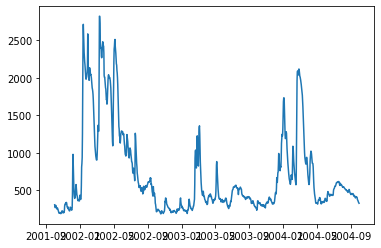

In [9]:
df_3yr = pd.concat([df_1994_wet, df_2008_dry, df_2006_avg], ignore_index=True)
plt.plot(df_3yr['datetime'], df_3yr['00060_Mean_cms'])

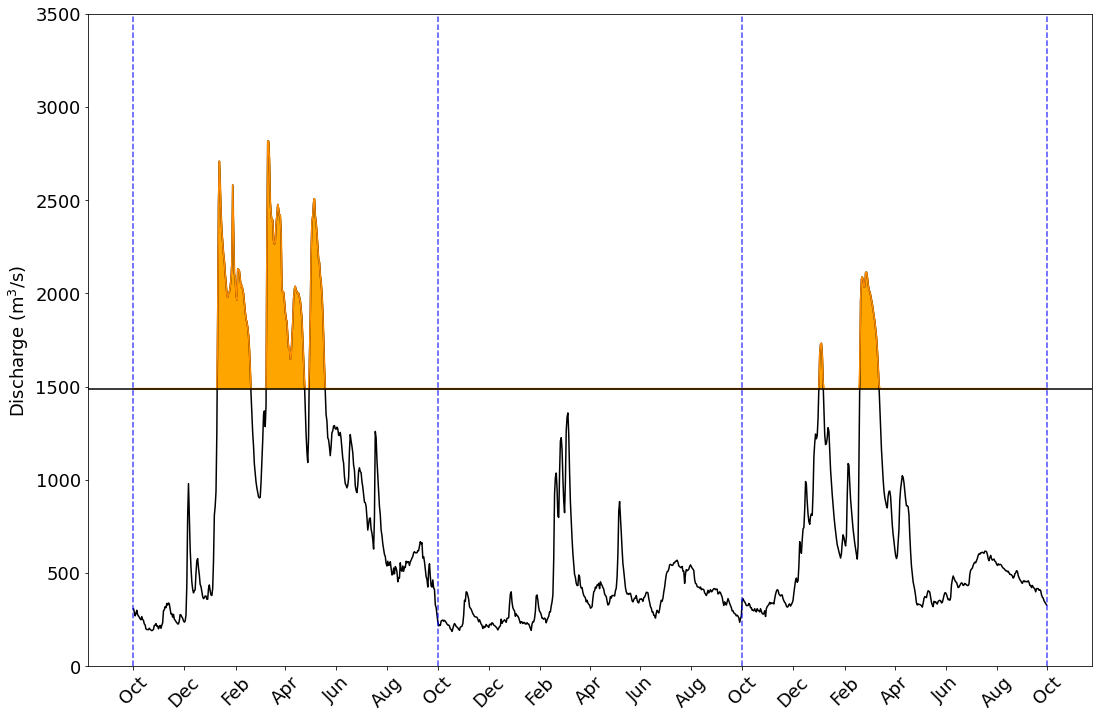

In [10]:
def plot_hmf_metric_figure(df, save=False):

    plt.figure(figsize=(18, 12))

    plt.plot(df["datetime"], df["00060_Mean_cms"], label="Streamflow", color="black")
    plt.plot(df["datetime"], threshold_cms+df["hmf_cms"], label="HMF", color="darkorange")
    plt.axhline(y=threshold_cms, color='black', linestyle='-', label='Threshold')

    #plt.fill_between(df["datetime"], df["00060_Mean_cms"], color="gray")
    plt.fill_between(df["datetime"], y1=threshold_cms, y2=threshold_cms+df["hmf_cms"], color="orange")

    # Plot vertical lines to separate water years
    first = True
    for year in range(df["datetime"].dt.year.min(), df["datetime"].dt.year.max() + 1):
        oct1 = pd.to_datetime(f'{year}-10-01')
        if first:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7, label='Hydro Year Start')
            first = False
        else:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7) 

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation
    plt.xticks(rotation=45, fontsize=18)
    #plt.xlabel("Date", fontsize=18)

    plt.yticks(fontsize=18)
    plt.ylabel('Discharge ($\mathregular{m^3}$/s)', fontsize=18)
    plt.ylim(0, 3500)

    #plt.title(f"{quantile*100:.0f}% Threshold", fontsize=20)
    #plt.grid(True)
    #plt.legend(loc=1, fontsize=16)
    
    
    # print(f'Year: {df_results["Year"][i]}')
    # print(f'Annual HMF: {annual_sum[i]}')
    # print(f'Event HMF: {df_results["event_hmf"][i]}')
    # print(f'Annual Duration: {df_results["total_days"][i]}')
    # print(f'Event Duration: {df_results["duration"][i]}')
    # print(f'Intra-Annual Frequency: {df_results["total_events"][i]}')
    # #print(f'Timing: {com_series.tolist()[i]}')
    # print(df_plot['hmf_cms'].tolist())
    
    if save == True:
        plt.savefig(f'Saved_Visuals/hmf_metric_figure.png', bbox_inches='tight', dpi=300)
        
    plt.show()
    
plot_hmf_metric_figure(df_3yr, save=True)

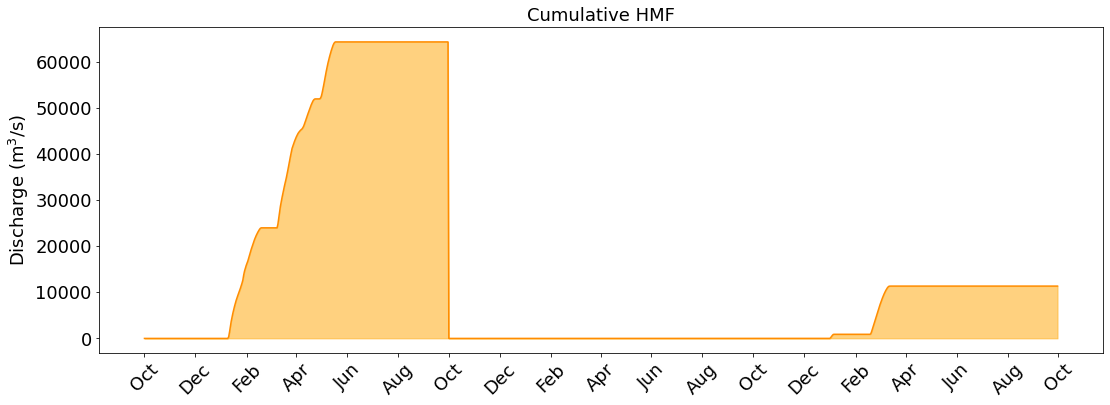

In [11]:
def calc_com_threshold(df):
    com_value = df['hmf_cms_cum'].iloc[-1] / 2
    return com_value

com_1 = calc_com_threshold(df_1994_wet)
com_2 = calc_com_threshold(df_2008_dry)
com_3 = calc_com_threshold(df_2006_avg)

def cum_hmf_plot(df):
    
    plt.figure(figsize=(18, 6))
    
    #com_value = df['hmf_cms_cum'].iloc[-1] / 2
    plt.plot(df['datetime'], df['hmf_cms_cum'], color='darkorange')
    #plt.axhline(y=com_value, color='black', linestyle='--', label='COM')
    plt.fill_between(df["datetime"], y1=0, y2=df['hmf_cms_cum'], color="orange", alpha=0.5)

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation
    plt.xticks(rotation=45, fontsize=18)
    
    plt.yticks(fontsize=18)
    plt.ylabel('Discharge ($\mathregular{m^3}$/s)', fontsize=18)
    #plt.ylim(0, 3500)
    
    plt.title('Cumulative HMF', fontsize=18)

    plt.show()
    
cum_hmf_plot(df_3yr)